# **AIPI 590 - XAI | Explainable Deep Learning**
### Explainable Deep Learning
### Lindsay Gross


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsaygross/explainable-deep-learning/blob/main/explainable-deep-learning.ipynb)


- Dataset Title: FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age


- Dataset citation:  

@inproceedings{karkkainenfairface,
  title={FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age for Bias Measurement and Mitigation},
  author={Karkkainen, Kimmo and Joo, Jungseock},
  booktitle={Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision},
  year={2021},
  pages={1548--1558}
}
- Collaborators: Karkkainen, Kimmo and Joo, Jungseock


## **Dependencies**

In [82]:
!pip install mtcnn grad-cam opencv-python matplotlib torch torchvision facenet-pytorch
!pip install facenet-pytorch grad-cam opencv-python matplotlib torch torchvision --quiet

from facenet_pytorch import InceptionResnetV1


%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from mtcnn import MTCNN
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Face detector & face model
from facenet_pytorch import MTCNN, InceptionResnetV1

# CAMs
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, LayerCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Make output dirs
os.makedirs("results", exist_ok=True)
os.makedirs("cropped", exist_ok=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Make folders
os.makedirs("results", exist_ok=True)
os.makedirs("cropped", exist_ok=True)


In [83]:
# define image paths
# Define your dataset (put images in same folder as notebook)
image_paths = [
    "race_Asian.jpg",
    "race_Black.jpg",
    "race_Latino.jpg",
    "race_Middle_Eastern.jpg",
    "race_White.jpg"
]

# Verify images exist
for p in image_paths:
    print(p, "exists" if os.path.exists(p) else "not found")

race_Asian.jpg exists
race_Black.jpg exists
race_Latino.jpg exists
race_Middle_Eastern.jpg exists
race_White.jpg exists


In [84]:
# Used ChatGPT5 at 9:15pm on 10/2/25 to help find best image size for MTCNN so that heatmap effectively covers face
# MTCNN detector 
mtcnn = MTCNN(image_size=160, margin=20, post_process=True, device=device)

def crop_align_face(input_path, output_path):
    
    # Load image
    # Used ChatGPT5 at 9:18pm on 10/2/25 to help with this block
    img = Image.open(input_path).convert("RGB") 
    try:
        face = mtcnn(img) 
    except Exception as e:
        face = None

    if face is None:
        print(f"No face detected in {input_path}; saving center-resized image.") # Used ChatGPT5 at 9:20pm on 10/2/25 to help with this print statement
        img_resized = img.resize((160,160)) # Used ChatGPT5 at 9:25pm on 10/2/25 to help with resize
        img_resized.save(output_path)
        return output_path, False

    # Convert tensor to PIL and save
    face_img = (face.permute(1,2,0).clamp(0,1).cpu().numpy()*255).astype(np.uint8) # Used ChatGPT5 at 9:30pm on 10/2/25to help with this conversion
    face_pil = Image.fromarray(face_img)
    face_pil.save(output_path)
    return output_path, True

# Run cropping
cropped_paths = []
for p in image_paths:
    out = os.path.join("cropped", os.path.basename(p)) # Used ChatGPT5 at 10:00pm on 10/2/25 to help with this line, specifically os.path.basename
    out, ok = crop_align_face(p, out) # returns path and bool if face detected
    cropped_paths.append(out)
    print(("yes" if ok else "no"), "Saved", out)

cropped_paths


yes Saved cropped/race_Asian.jpg
yes Saved cropped/race_Black.jpg
yes Saved cropped/race_Latino.jpg
yes Saved cropped/race_Middle_Eastern.jpg
yes Saved cropped/race_White.jpg


['cropped/race_Asian.jpg',
 'cropped/race_Black.jpg',
 'cropped/race_Latino.jpg',
 'cropped/race_Middle_Eastern.jpg',
 'cropped/race_White.jpg']

In [85]:
# Load pretrained face model & set target layer
from torchvision import transforms

# Pretrained face model
model = InceptionResnetV1(pretrained='vggface2').eval().to(device) # Used ChatGPT5 at 10:10pm on 10/2/25 to help with how to create this feature extractor

target_layer = model.block8  # changed to block8 based on ChatGPT5 suggestion at 10:15pm on 10/2/25 because wasn't accurate otherwise

# Preprocessing to [-1,1] at 160x160
# Used ChatGPT5 at 10:30pm on 10/2/25 to help with understanding how to use InceptionResnetV1 
to_tensor = transforms.Compose([
    transforms.ToTensor(),                 
    transforms.Normalize([0.5,0.5,0.5],    
                         [0.5,0.5,0.5]),
])


In [86]:
# Resnet18 for comparison
# Used ChatGPT5 at 11:00pm on 10/2/25 to help with this block and the suggestion to use resnet18 for comparison

model = models.resnet18(pretrained=True) # Used ChatGPT5 at 11:00pm on 10/2/25 to help resnet18 
model.eval()
target_layer = model.layer4[-1]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [87]:
# function to run CAMs

def show_heatmaps(image_path, cams, save_path=None):
    raw_img = cv2.imread(image_path)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB because OpenCV uses BGR by default. Used ChatGPT5 at 11:05pm on 10/2/25 to help with this line/understanding why 

    fig, axs = plt.subplots(1, len(cams)+1, figsize=(15,5)) # Used ChatGPT5 at 11:05pm on 10/2/25 to help with figure size

    axs[0].imshow(raw_img)
    axs[0].set_title("Input")
    axs[0].axis("off")
# Used ChatGPT5 at 11:10pm on 10/2/25 to help with code block for loop to display heatmaps
    for idx, (name, cam) in enumerate(cams.items(), start=1):
        overlay = show_cam_on_image(raw_img.astype(np.float32) / 255.0, cam, use_rgb=True)
        axs[idx].imshow(overlay)
        axs[idx].set_title(name)
        axs[idx].axis("off") 

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight") # Used ChatGPT5 at 11:15pm on 10/2/25 to help with this line 
        print(f"Saved heatmap to {save_path}")
    plt.show()


In [88]:
# CAM runner 
# Used ChatGPT5 at 12:30am on 10/3/25 to help with this code block
def load_rgb_160(path): # needed to change to 160 to match input size
    im = Image.open(path).convert("RGB").resize((160,160)) 
    rgb = np.array(im).astype(np.uint8)             # for visualization
    inp = to_tensor(im).unsqueeze(0).to(device)     # model tensor
    return rgb, inp

def run_cams(img_path, model, target_layer, smoothing=True, save_tag=None):
    rgb, input_tensor = load_rgb_160(img_path)

    cams = {
        "GradCAM":   GradCAM(model=model, target_layers=[target_layer]),
        "GradCAM++": GradCAMPlusPlus(model=model, target_layers=[target_layer]),
        "LayerCAM":  LayerCAM(model=model, target_layers=[target_layer]),
    }

    fig, axs = plt.subplots(1, len(cams)+1, figsize=(15,4))
    axs[0].imshow(rgb); axs[0].set_title("Input"); axs[0].axis("off") # Used ChatGPT5 at 12:30am on 10/3/25 to help with this line

    heatmaps = {}
    for i, (name, cam_algo) in enumerate(cams.items(), start=1): # Used ChatGPT5 at 11:50pm on 10/2/25 to help with this line
        grayscale_cam = cam_algo( # Used ChatGPT5 at 11:50pm on 10/2/25 to help know to use grayscale to pass the CAMs into show_cam_on_image to create the overlay
            input_tensor=input_tensor,
            aug_smooth=bool(smoothing), # Used ChatGPT5 at 11:50pm on 10/2/25 to help with smoothing to improve results
            eigen_smooth=bool(smoothing) # Used ChatGPT5 at 11:50pm on 10/2/25 to help with smoothing to improve results
        )[0, :]
        heatmaps[name] = grayscale_cam 
        overlay = show_cam_on_image((rgb/255.0).astype(np.float32), # Used ChatGPT5 at 11:50pm on 10/2/25 to help with this line
                                    grayscale_cam, use_rgb=True) 
        axs[i].imshow(overlay); axs[i].set_title(name); axs[i].axis("off") # Used ChatGPT5 at 12:30am on 10/3/25 to help with this line

    plt.tight_layout()
    if save_tag:
        out = os.path.join("results", f"{os.path.basename(img_path).split('.')[0]}_{save_tag}.png") # create filename for each image 
        fig.savefig(out, dpi=150) # Used ChatGPT5 at 12:30am on 10/3/25 to help with dpi=150 
        print(f"Saved {out}")
    plt.show()

    return heatmaps


Running CAMs on aligned (cropped) faces
Saved results/race_Asian_face_cams.png


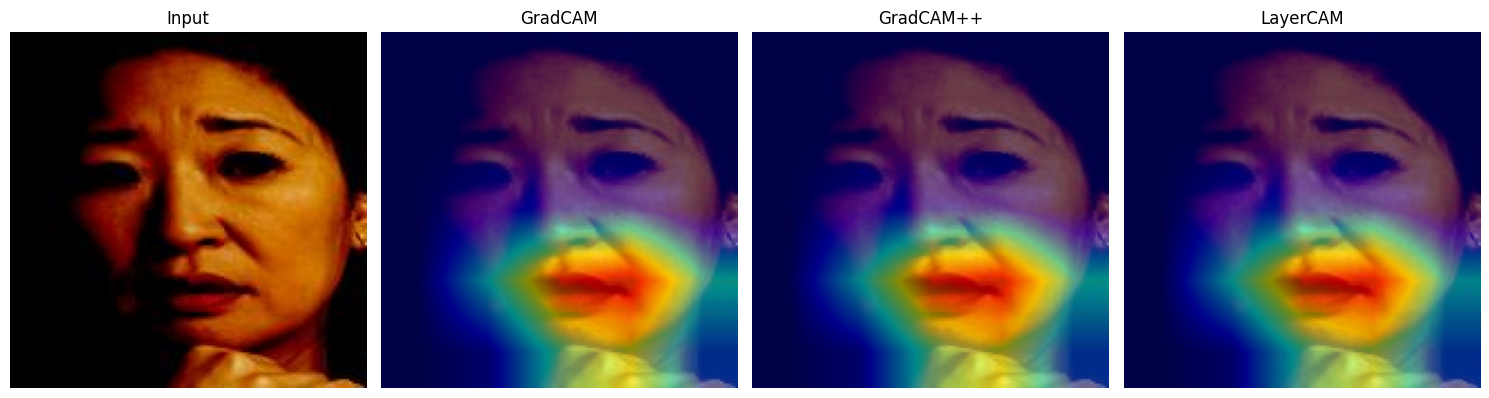

Saved results/race_Black_face_cams.png


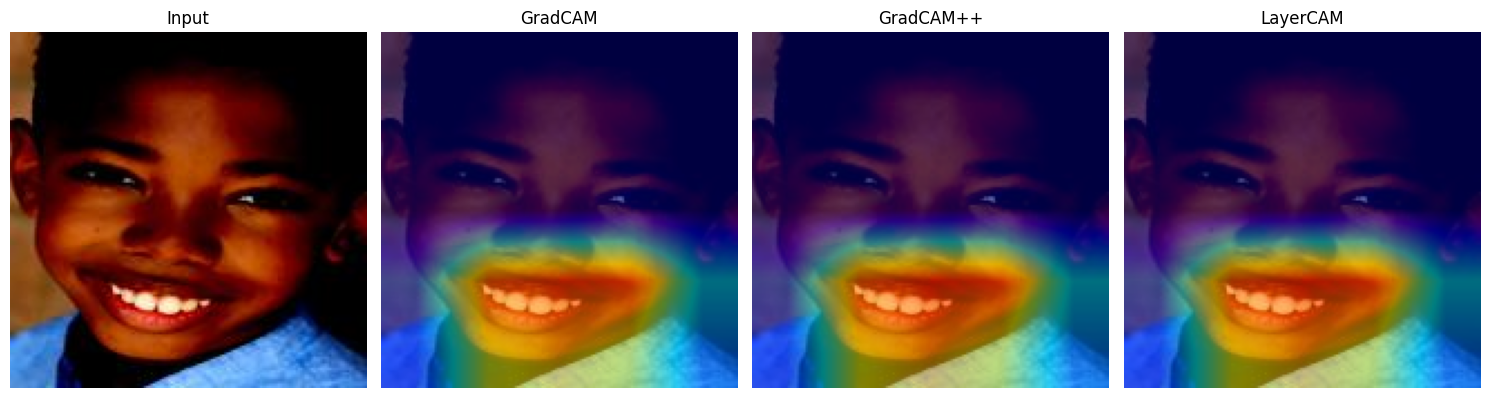

Saved results/race_Latino_face_cams.png


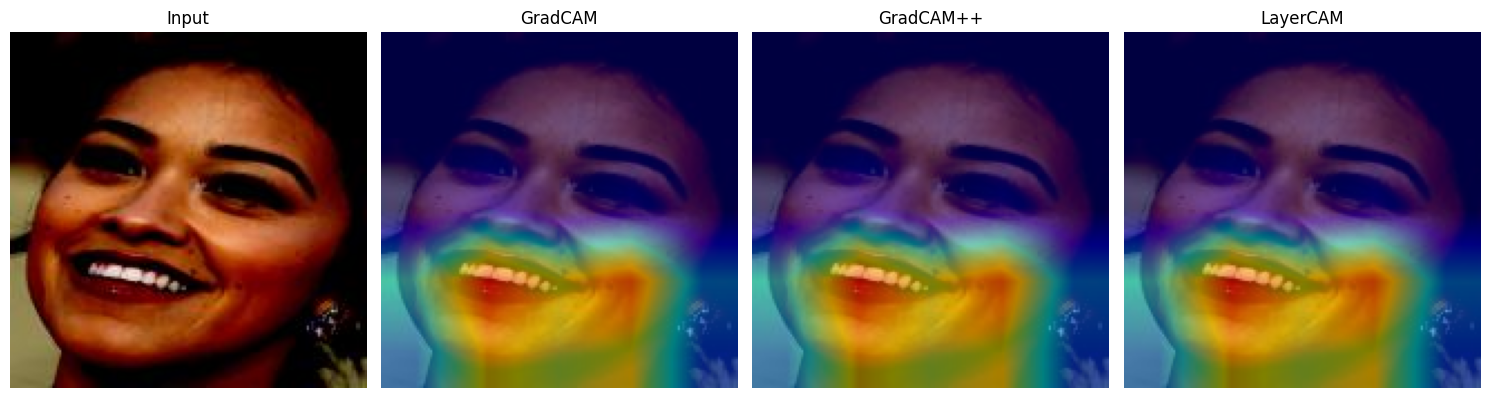

Saved results/race_Middle_Eastern_face_cams.png


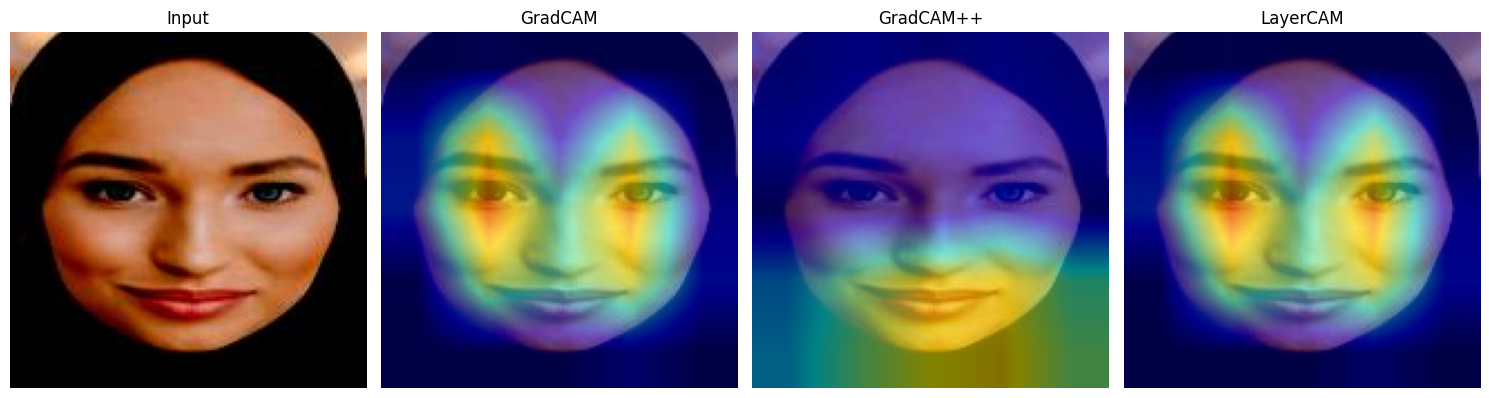

Saved results/race_White_face_cams.png


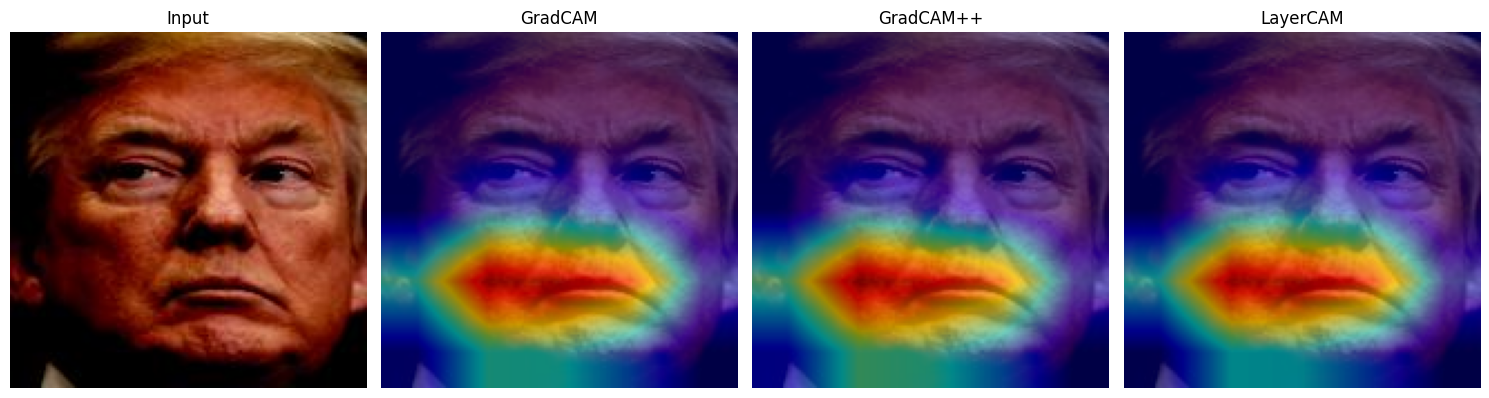

In [89]:
# run cams
print("Running CAMs on aligned (cropped) faces")
for p in cropped_paths:
    cams = run_cams(p, model, target_layer, smoothing=True, save_tag="face_cams")

## "Asian Face" Image

For the Asian face, all three methods (GradCAM, GradCAM++, and LayerCAM) focused most on the mouth and chin region. This suggests that the model is learning on the lower facial features rather than the whole face.  

This is surprising because humans typically rely on eyes and upper-face features for recognition. The lack of attention to the eyes may indicate the model is not using the most informative or generalizable features, raising concerns about robustness and effectiveness when comparing it to how humans recognize faces. 


## "Black Face" Image

For the Black face, the CAM visualizations also concentrated on the mouth and teeth.

This can be misleading because the model may be associating smiling or visible teeth as key identity cues. This could possibly lead to errors when someone isn't smiling, which raises questions about the model's reproducibility. 


## "Latino Face" Image

The Latino face results are similar to the other results, focusing most on the lower facial features. 

This suggests the model may be **overfitting** to expression-related features (smiles) rather than identity features. This may be problematic because it may mean that identity predictions could vary across photos of the same person depending on facial expression.  


## "Middle Eastern Face" Image

The pesron in this image is not smiling with their teeth, and the model did not concentrate on the lower features. This might suggest that the model prioritizes a smile and is more accurate/focuses on the entire face if the person is not showing a particular emotion.  

This inconsistency suggests the model may not rely on uniform features.

## "White Face" Image

For the White face, the CAM results highlight the mouth very strongly, even though the individual is not smiling.

This reliance on mouth shape could be risky because it may tie identity too closely to speech, expression, or lip movement. 

Running background-blurred comparisons on ALL images
Saved results/blur_race_Asian_blur_race_Asian_cams.png


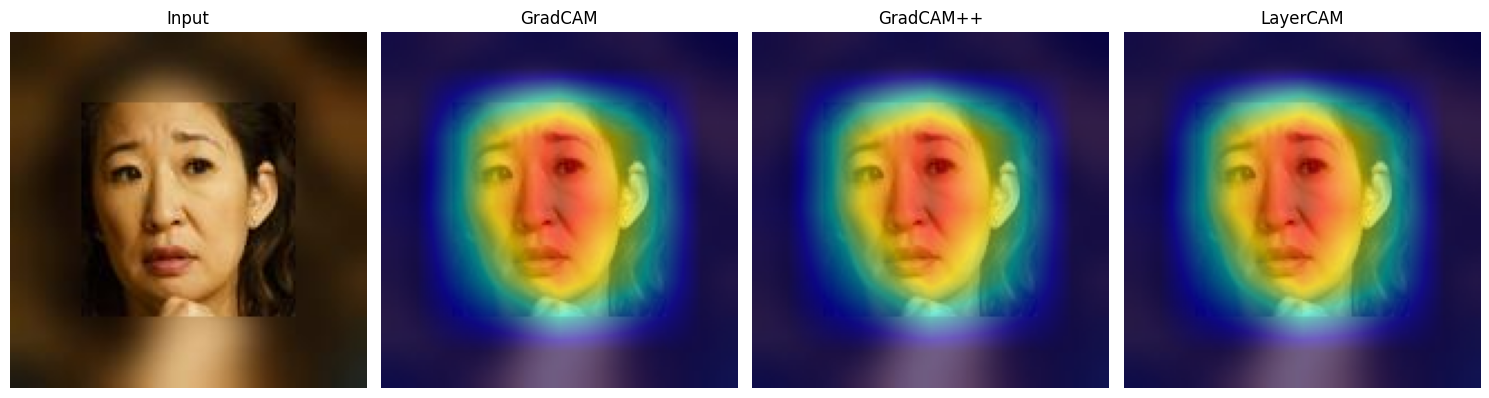

Saved results/blur_race_Black_blur_race_Black_cams.png


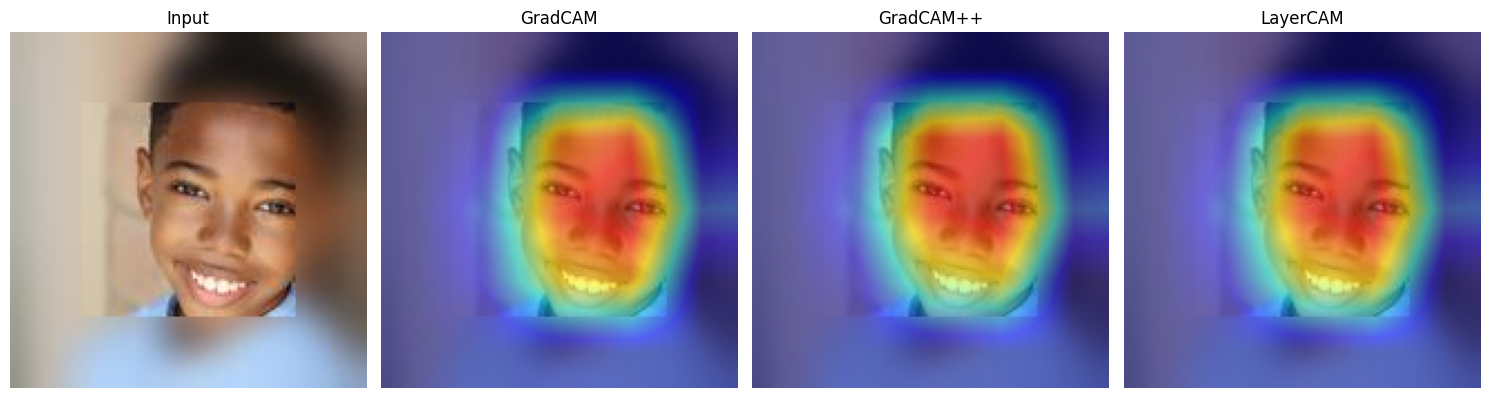

Saved results/blur_race_Latino_blur_race_Latino_cams.png


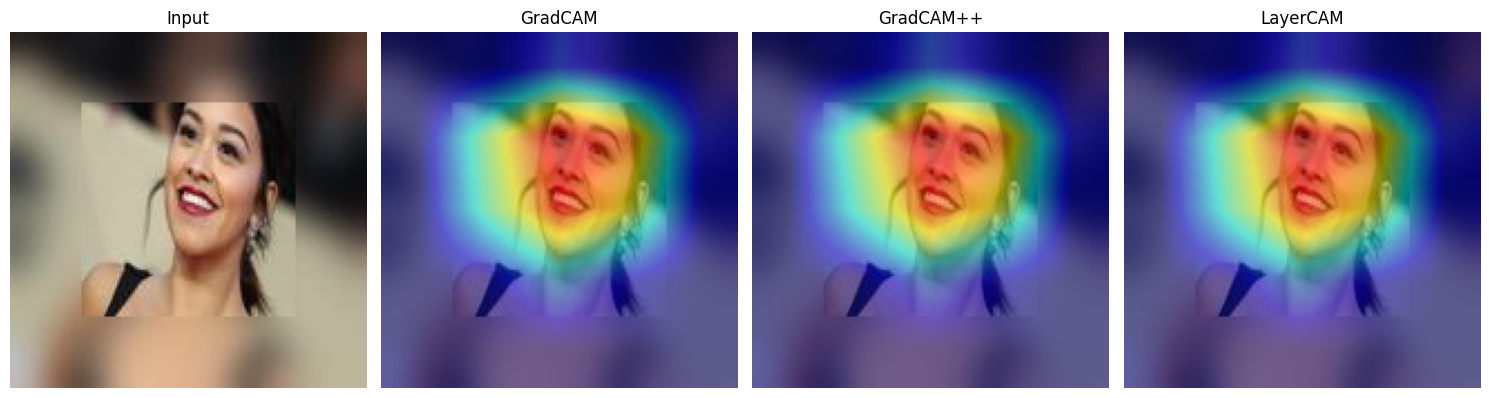

Saved results/blur_race_Middle_Eastern_blur_race_Middle_Eastern_cams.png


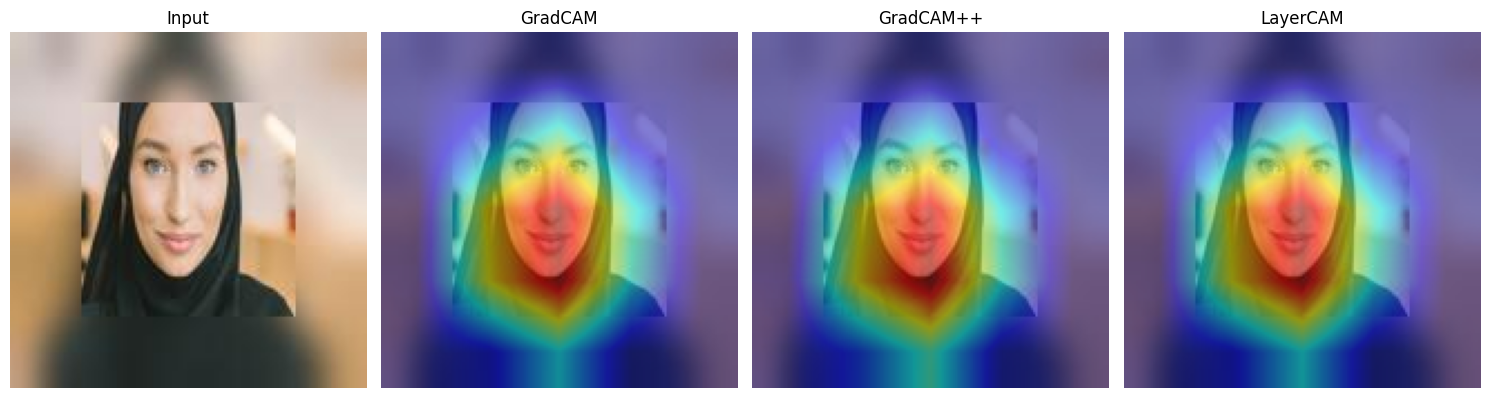

Saved results/blur_race_White_blur_race_White_cams.png


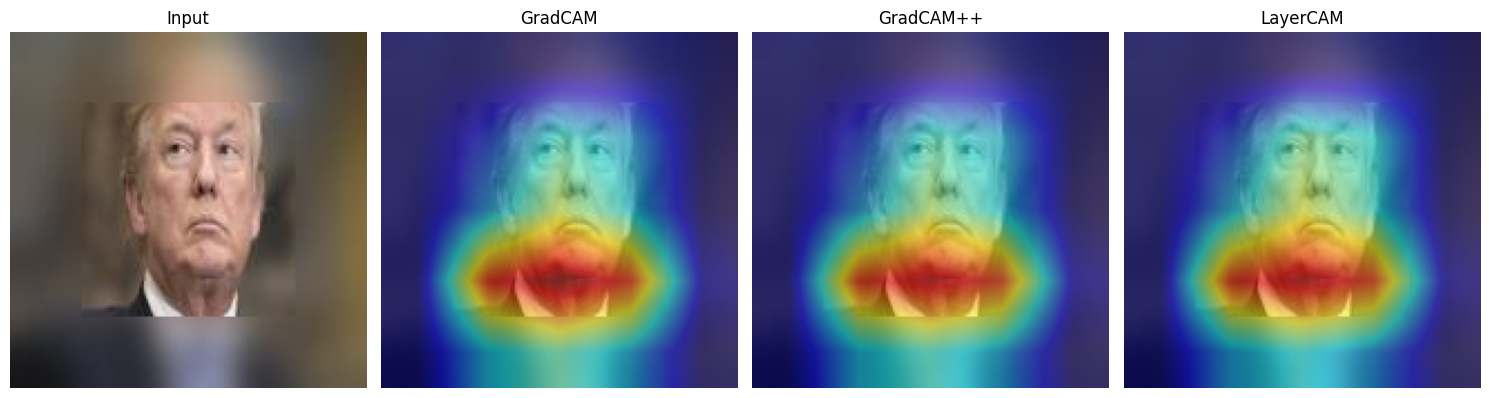

In [90]:
# Background-blurred input comparison 
# Used ChatGPT5 at 12:45am on 10/3/25 to help with this section 

def blur_bg_with_center_face(orig_path, out_path, face_size=160):
    """
    Creates an image with the face and blurred background
    """
    im = Image.open(orig_path).convert("RGB").resize((face_size, face_size))
    rgb = np.array(im)
    blurred = cv2.GaussianBlur(rgb, (51, 51), 0)

    # Keep the face sharp, blur the rest
    mask = np.zeros((face_size, face_size), np.uint8)
    s = int(face_size * 0.6)
    x0 = (face_size - s) // 2
    y0 = (face_size - s) // 2
    mask[y0:y0+s, x0:x0+s] = 1

    out = (rgb*mask[...,None] + blurred*(1-mask[...,None])).astype(np.uint8)
    Image.fromarray(out).save(out_path)
    return out_path


print("Running background-blurred comparisons on ALL images")
blurred_paths = []

for p in image_paths:
    out = os.path.join("cropped", f"blur_{os.path.basename(p)}")
    tmp_path = blur_bg_with_center_face(p, out)
    blurred_paths.append(tmp_path)

    # run cams
    cams = run_cams(tmp_path, model, target_layer, smoothing=True,
                    save_tag=f"blur_{os.path.basename(p).split('.')[0]}_cams")


# Addition of Blur Experiment

We introduced the background blur step because in the cropped-only results, the CAMs seemed to focus too heavily on the mouth region across all faces. We wanted to test whether part of this behavior came from distracting background information rather than the model truly focusing on identity-related features.

By blurring the background and keeping the the face as the priority, the model doesn't rely on irrelevant areas outside the face. This allows us to compare whether the heatmaps shift toward more meaningful cues (like eyes or full-face structure) when the background is removed as a factor.

## Asian Face (Blurred)

With the background blurred, the CAMs focused much more consistently on the **entire face region** rather than just the mouth. GradCAM and GradCAM++ highlighted the **eyes, nose, and cheeks**, while LayerCAM distributed attention across the face.  

This suggests that background noise was probably distracting the model in the cropped images that were not blurred. Without the backgroubnd, the model relies more holistic facial features, which is a more reliable basis for recognition.


## Black Face (Blurred)

In the blurred version of the Black face, the heatmaps show focus across the eyes and central face region. This indicates that background blur encourages the model to use **broader identity cues** instead of overfitting to expression-related features (like the smile).

## Latino Face (Blurred)

For the Latino face, blurring also helped move the attention from the mouth to the rest of the face.  

This is a significant improvement because it suggests the model is more holistic and focuses on identity-based features instead of relying solely on expression.


## Middle Eastern Face (Blurred)

For the middle eastern face, With the background blurred, the CAMs show strong focus on the center of the face, especially the eyes and nose. GradCAM++ and LayerCAM both highlight the upper half of the face much more clearly than in the non-blurred version.  

This demonstrates the effectiveness of background blurring because without the outside distraction, the model pays attention to the most human-recognizable features for identification.


## White Face (Blurred)

For the White face, the blurred background also improved attention distribution, but not by much.GradCAM, GradCAM++ and LayerCAM also still put a strong emphasis on the lower face.



## Interpretation of Focus

Across all images, the GradCAM, GradCAM++, and LayerCAM visualizations consistently highlight regions around the entire face, not just the mouth. This suggests the model is relying on the entire face for its predictions.  

One surprising finding is that the eyes were rarely emphasized. Since humans typically rely on the eyes as highly distinctive features, this was interesting.

Also, in some images, the heatmaps leaked into the background (ex: latino face and middle eastern face), showing the model may not always concentrate on the most relevant features. However, the blurred-background experiments significantly improved this by forcing attention onto the face.


## Surprising or Misleading Results

- The model often focused on the **lower half of the face** (chin, jaw, mouth), which may not be the most reliable or generalizable cue.  
- Heatmaps sometimes extended beyond the face into clothing or the background, suggesting the model could be influenced by outside context.  
- For some groups (e.g., Latino and Middle Eastern faces), there were symmetric patterns across the cheeks, which don’t clearly connect to meaningful distinguishing features.  

## Fairness Implications

- If the model attends to **skin tone or lighting** instead of true facial features, it may systematically misclassify some demographic groups.  
- Background influence means predictions could unfairly vary depending on **context of the photo**.  
- Unequal attention patterns across races risk amplifying **biases** in tasks like identification or classification, especially if someone is smiling or not. 

This shows the importance of bias audits, transparency and explainability of models before being deployed in real-world systems.  


## Limitations

- **Coloring:**: The coloring of the first test appeared to have a filter on it which may have affected the effectiveness of the model.
**Resolution & Preprocessing:** the resize to 160×160 may distort key features.  
- **CAM methods:** GradCAM shows sensitivity, but this does not always **causality**.  
- **Dataset size:** only **five** faces were tested, which is not enough to make broad claims about bias.  
- **Architecture dependence:** different layers in the network can produce different CAM results, so findings are tied to this specific setup.  


## Why Explainability Matters

Explainability is essential in **sensitive domains like face analysis**. Without visualizations, we would not know that the model is disproportionately focusing on mouths and jawlines instead of eyes or other meaningful cues.  

Using CAM methods allows us to:  
- Detect when the model is relying on **irrelevant background details**.  
- Compare whether different groups receive **similar or different attention patterns**.  
- Evaluate whether the model is actually learning **meaningful, generalizable features** or taking shortcuts.  


## Comparison: Cropped vs. Blurred Faces

When comparing the cropped images to the blurred-background versions, the following patterns emerged:

- **Unblurred/Cropped Faces:**  
  The model often overemphasized the **mouth and lower face region**, especially for images where subjects were smiling. This suggests that expression-related features (like teeth and lips) were disproportionately affecting the CAM activations. While these cues can be correlated with identity in training data, they are not the most stable or fair indicators for recognition.

- **Blurred Background Faces:**  
  After applying background blur, the model’s attention shifted toward a **broader set of facial features**. This aligns more closely with how humans recognize faces and provides a more balanced distribution of focus. The results indicate that background removal or reduction helps the model avoid distraction and reduces reliance on a single facial feature.

### Key Takeaways
**Explainability Matters:** CAM visualizations reveal that the model’s raw attention can be biased toward expressions rather than stable identity features. Without explainability, this bias might remain hidden.
**Fairness Implications:** If models disproportionately rely on smiles or mouth regions, groups with different cultural or social expressions may be treated unfairly. Background blur appears to improve fairness by encouraging more consistent attention.

Overall, **blurred background preprocessing improved focus consistency across all groups**, but it is not a complete solution. Explainability tools like CAMs are important for identifying these biases and iterating on model design in fairness-sensitive domains such as face analysis.
